# Just a test from copilot

### Individual EOF analysis of SST, SSS and mlt

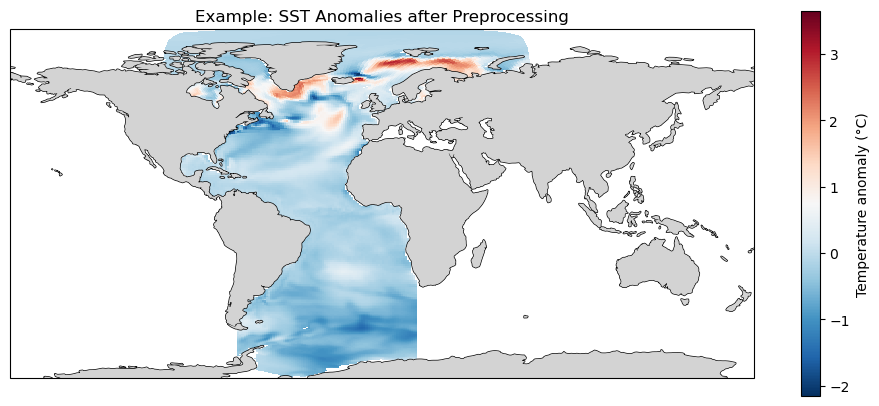

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -----------------------------
# 1. Load data
# -----------------------------
thetao_path = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked.nc"
so_path = "/data/projects/nckf/frekle/CMIP6_data/so/so_masked.nc"

thetao = xr.open_dataset(thetao_path)["thetao"]   # 3D temperature [time, lev, j, i]
so = xr.open_dataset(so_path)["so"]               # 3D salinity [time, lev, j, i]

# -----------------------------
# 2. Extract surface layers (lev = 0)
# -----------------------------
sst = thetao.isel(lev=0)  # Sea Surface Temperature
sss = so.isel(lev=0)      # Sea Surface Salinity

# -----------------------------
# 3. Compute anomalies (remove time mean)
# -----------------------------
sst_anom = sst - sst.mean(dim='time')
sss_anom = sss - sss.mean(dim='time')

# -----------------------------
# 4. Compute cosine-latitude weights
# -----------------------------
lat = sst["latitude"]
weights = np.sqrt(np.cos(np.deg2rad(lat)))

# -----------------------------
# 5. Plot example: SST anomalies (first timestep)
# -----------------------------
fig = plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_title("Example: SST Anomalies after Preprocessing")
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)

pcm = ax.pcolormesh(
    sst["longitude"], sst["latitude"], sst_anom.isel(time=0),
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    shading="auto"
)
plt.colorbar(pcm, ax=ax, orientation='vertical', label="Temperature anomaly (°C)")
plt.show()

# save plot as png
# plt.savefig('example_sst_anomalies.png', dpi=300)

Variance explained by first 3 EOFs:
SST: [45.64977  10.584513  5.334278]
SSS: [26.017014  9.965987  6.661688]
MLT: [29.18344  13.51998   7.189086]


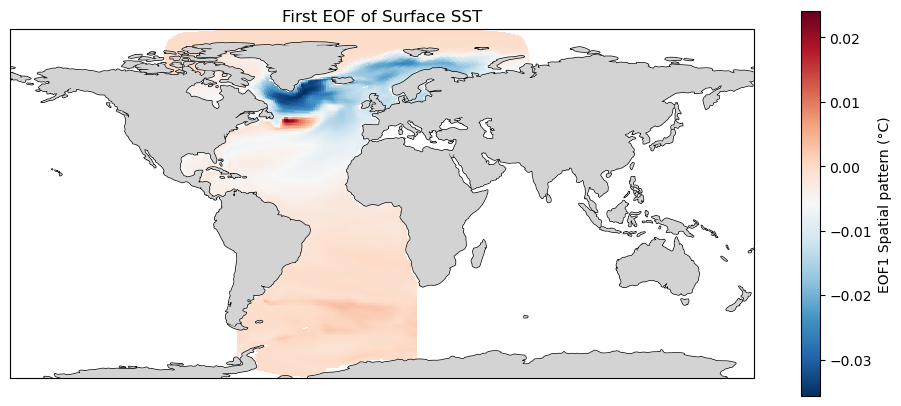

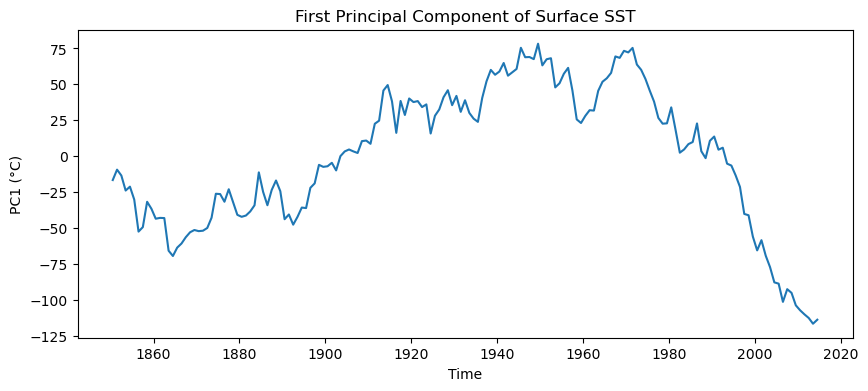

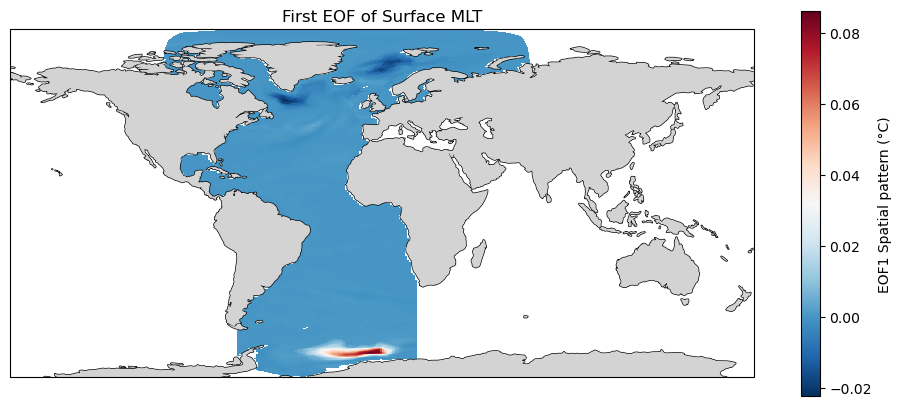

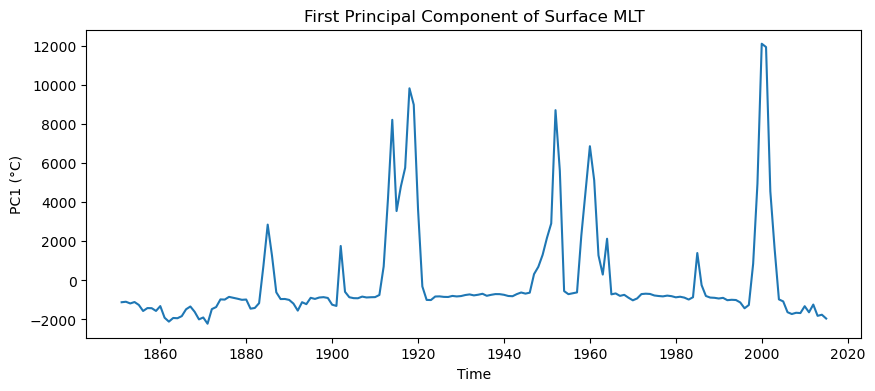

In [2]:
# ==============================================================
# 6. EOF analysis
# ==============================================================

from eofs.xarray import Eof
from scipy.stats import pearsonr
import xarray as xr
import matplotlib.pyplot as plt

# sst_anom, sss_anom, weights are already defined

# -----------------------------
# 1. Load MLT data
# -----------------------------
mlt_path = "/data/projects/nckf/frekle/CMIP6_data/mlotst/mlotst_masked.nc"
mlt = xr.open_dataset(mlt_path)["mlotst"]

# Extract surface/near-surface layer if needed (depends on data shape)
# For mixed layer thickness it might already be 2D (time, lat, lon)
mlt_anom = mlt - mlt.mean(dim='time')  # anomalies

# -----------------------------
# 1. Function to compute EOFs and PCs
# -----------------------------
def compute_eofs(data, weights, n_modes=3):
    solver = Eof(data, weights=weights)
    eofs = solver.eofs(neofs=n_modes)
    pcs = solver.pcs(npcs=n_modes)
    variance = solver.varianceFraction(neigs=n_modes)
    return eofs, pcs, variance

# -----------------------------
# 2. Compute EOFs
# -----------------------------
eofs_sst, pcs_sst, var_sst = compute_eofs(sst_anom, weights)
eofs_sss, pcs_sss, var_sss = compute_eofs(sss_anom, weights)
eofs_mlt, pcs_mlt, var_mlt = compute_eofs(mlt_anom, weights)

# -----------------------------
# 5. Plot EOFs and PCs
# -----------------------------
def plot_eofs_pcs(eofs, pcs, variance, varname):
    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    for i in range(3):
        # EOF spatial pattern
        im = eofs[i].plot(ax=axes[i, 0], cmap='RdBu_r', add_colorbar=True)
        axes[i, 0].set_title(f'{varname} EOF {i+1} ({variance[i].values*100:.1f}% var)')

        # PC time series
        pcs[:, i].plot(ax=axes[i, 1])
        axes[i, 1].set_title(f'{varname} PC {i+1}')
    plt.tight_layout()
    # plt.show()

# plot_eofs_pcs(eofs_sst, pcs_sst, var_sst, 'SST')
# plot_eofs_pcs(eofs_sss, pcs_sss, var_sss, 'SSS')

# print variance explained
print("Variance explained by first 3 EOFs:")
print("SST:", var_sst[:3].values * 100)
print("SSS:", var_sss[:3].values * 100)
print("MLT:", var_mlt[:3].values * 100)

# Plot first EOF with cartopy
fig = plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_title("First EOF of Surface SST")
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)

pcm = ax.pcolormesh(
    sst["longitude"], sst["latitude"], eofs_sst.isel(mode=0),
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    shading="auto"
)
plt.colorbar(pcm, ax=ax, orientation='vertical', label="EOF1 Spatial pattern (°C)")
plt.show()

# plot first PC
plt.figure(figsize=(10,4))
pc1 = pcs_sst.isel(mode=0)
pc1.plot()
plt.title('First Principal Component of Surface SST')
plt.xlabel('Time')
plt.ylabel('PC1 (°C)')
plt.show()

# Plot first EOF and PC of MLT with cartopy

fig = plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("First EOF of Surface MLT")
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)
pcm = ax.pcolormesh(
    mlt["longitude"], mlt["latitude"], eofs_mlt.isel(mode=0),
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    shading="auto"
)
plt.colorbar(pcm, ax=ax, orientation='vertical', label="EOF1 Spatial pattern (°C)")
plt.show()

plt.figure(figsize=(10,4))
pc1 = pcs_mlt.isel(mode=0)
pc1.plot()
plt.title('First Principal Component of Surface MLT')
plt.xlabel('Time')
plt.ylabel('PC1 (°C)')
plt.show()


# Correlating single variable with the AMOC index (msftyz)

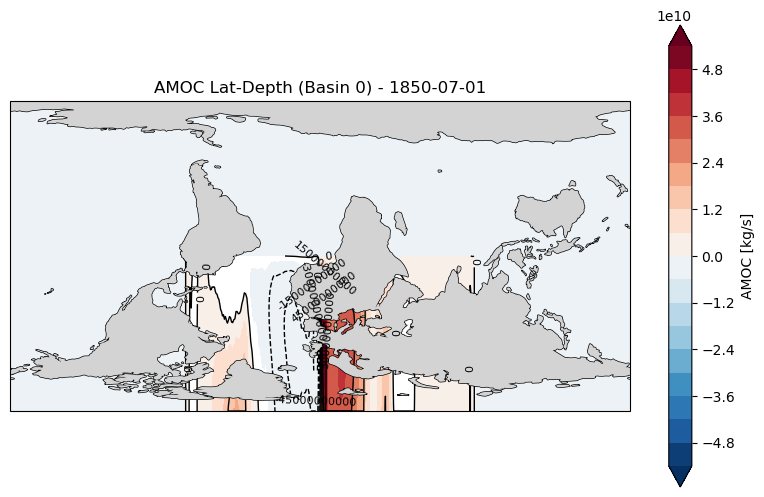

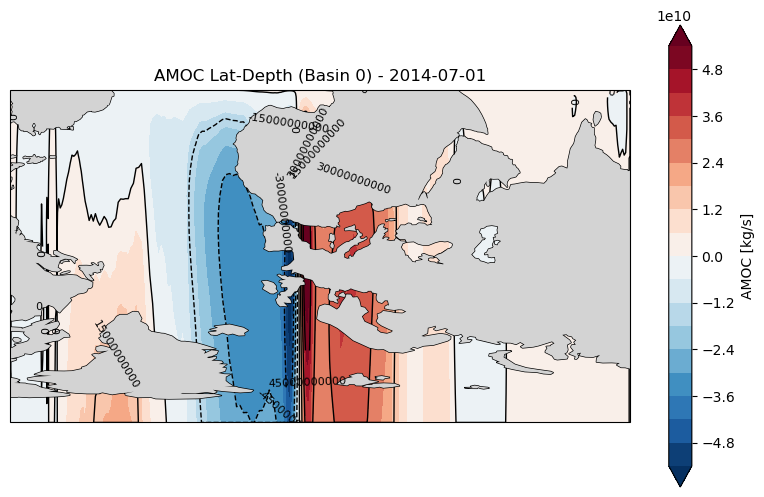

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load data
msftyz_path = "/data/projects/nckf/frekle/CMIP6_data/msftyz/msftyz_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
msftyz = xr.open_dataset(msftyz_path)["msftyz"]

# Select Atlantic basin
msftyz_atl = msftyz.sel(basin=0)  # shape: (time, lev, rlat)

# Extract coordinates
lat = msftyz_atl['rlat'].values
lev = msftyz_atl['lev'].values
times = msftyz_atl['time'].values

# Create 2D meshgrid for plotting
LAT, LEV = np.meshgrid(lat, lev)  # shape (lev, rlat)

# Choose first and last time steps
time_steps = [0, -1]

for t in time_steps:
    Z = msftyz_atl.isel(time=t).values

    fig = plt.figure(figsize=(10,6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Filled contour (strength)
    cf = ax.contourf(LAT, LEV, Z, levels=20, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
    # Contour lines (circulation)
    cs = ax.contour(LAT, LEV, Z, levels=10, colors='k', linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=8)

    # Invert y-axis for depth
    ax.invert_yaxis()

    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)
    ax.add_feature(cfeature.COASTLINE)

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Depth (m)')
    ax.set_title(f'AMOC Lat-Depth (Basin 0) - {str(times[t])[:10]}')

    # Colorbar
    cbar = plt.colorbar(cf, ax=ax, orientation='vertical', label='AMOC [kg/s]')

    plt.show()


In [4]:
# Load AMOC data
msftyz_path = "/data/projects/nckf/frekle/CMIP6_data/msftyz/msftyz_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
msftyz = xr.open_dataset(msftyz_path)["msftyz"]

# Select Atlantic basin (assume basin=0) and ~26N, ~1000m
amoc_index = msftyz.isel(basin=0).sel(rlat=26, lev=1000, method='nearest').squeeze()

# Interpolate MLT to match SST time dimension
pcs_mlt = pcs_mlt.interp(time=pcs_sst.time)

# Align time coordinates
common_time = np.intersect1d(pcs_sst.time, amoc_index.time)
pcs_sst_aligned = pcs_sst.sel(time=common_time)
pcs_sss_aligned = pcs_sss.sel(time=common_time)
pcs_mlt_aligned = pcs_mlt.sel(time=common_time)
amoc_aligned = amoc_index.sel(time=common_time)


   PC  Correlation       p_value Variable
0   1    -0.471269  1.673609e-10      SSS
0   1    -0.406631  5.973792e-08      SST
2   3     0.268153  4.971280e-04      SST
2   3     0.162573  3.695008e-02      SSS
1   2    -0.127466  1.027748e-01      SST
1   2     0.070088  3.710259e-01      SSS
0   1          NaN           NaN      MLT
1   2          NaN           NaN      MLT
2   3          NaN           NaN      MLT


/tmp/ipykernel_3316151/2548710115.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_all = pd.concat([corr_sst, corr_sss, corr_mlt])


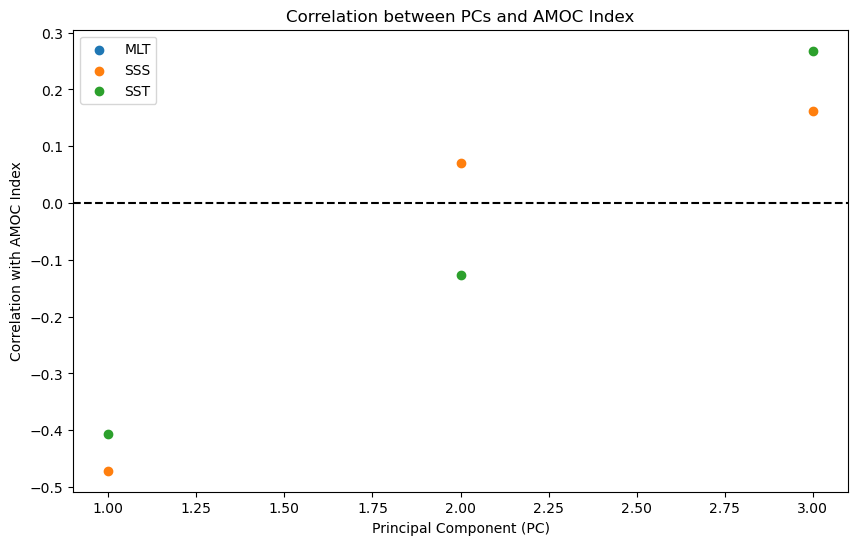

In [5]:
from scipy.stats import pearsonr
import pandas as pd

def correlate_pcs_with_amoc(pcs, amoc, varname):
    corrs = []
    pvals = []
    n_modes = pcs.shape[1]
    
    for i in range(n_modes):
        r, p = pearsonr(pcs[:, i], amoc)
        corrs.append(r)
        pvals.append(p)
    
    df = pd.DataFrame({
        'PC': np.arange(1, n_modes+1),
        'Correlation': corrs,
        'p_value': pvals
    })
    df['Variable'] = varname
    return df

corr_sst = correlate_pcs_with_amoc(pcs_sst_aligned, amoc_aligned, 'SST')
corr_sss = correlate_pcs_with_amoc(pcs_sss_aligned, amoc_aligned, 'SSS')
corr_mlt = correlate_pcs_with_amoc(pcs_mlt_aligned, amoc_aligned, 'MLT')

corr_all = pd.concat([corr_sst, corr_sss, corr_mlt])
print(corr_all.sort_values('Correlation', key=abs, ascending=False))

# plot correlation between PCs and AMOC index
plt.figure(figsize=(10,6))
for varname, group in corr_all.groupby('Variable'):
    plt.scatter(group['PC'], group['Correlation'], label=varname)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Principal Component (PC)')
plt.ylabel('Correlation with AMOC Index')
plt.title('Correlation between PCs and AMOC Index')
plt.legend()
plt.show()


### With a function and spatial map

/data/users/frekle/EOF/analysis_helpers.py:242: UserWarning: No latitude/longitude coords found; plotting with image indices.
  warnings.warn('No latitude/longitude coords found; plotting with image indices.')
/data/users/frekle/EOF/analysis_helpers.py:242: UserWarning: No latitude/longitude coords found; plotting with image indices.
  warnings.warn('No latitude/longitude coords found; plotting with image indices.')
/data/users/frekle/EOF/analysis_helpers.py:242: UserWarning: No latitude/longitude coords found; plotting with image indices.
  warnings.warn('No latitude/longitude coords found; plotting with image indices.')


<GeoAxes: title={'center': 'Correlation: MLT vs AMOC (FDR)'}>

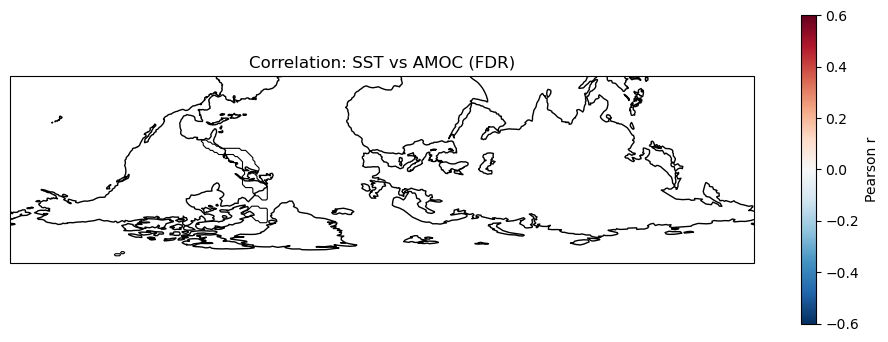

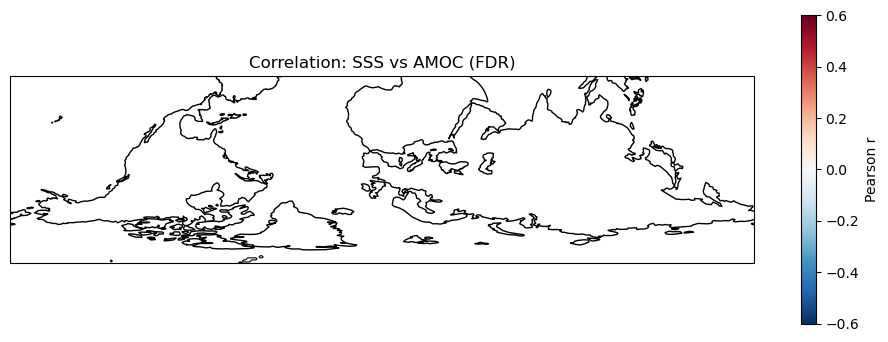

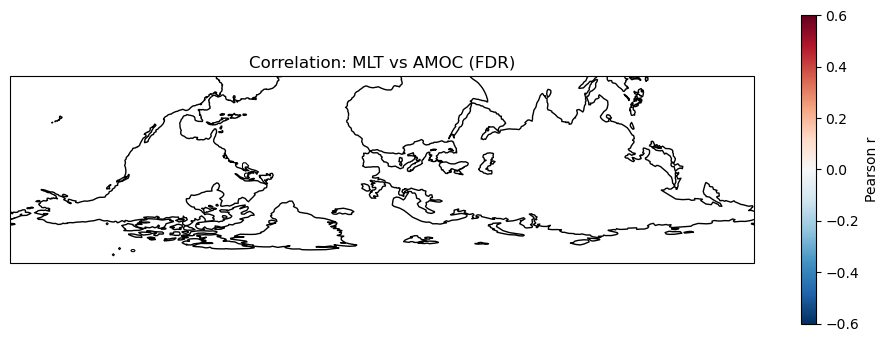

In [ ]:
# -------------------------------------------------------------
# Compute Pearson correlation maps between variables and AMOC (using helper module)
# Demonstrates chunked/dask-backed computation and FDR-corrected significance contours
# -------------------------------------------------------------
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Use the helper functions implemented in EOF/analysis_helpers.py
# Make sure the repository root is on sys.path so 'EOF' is importable when executing
import sys, os
repo_root = '/data/users/frekle'
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
from EOF.analysis_helpers import pearson_map, plot_map_with_significance

# Interpolate MLT to match SST time dimension (as before)
mlt_anom = mlt_anom.interp(time=sst_anom.time)

# Ensure datasets share a common time coordinate
common_time = np.intersect1d(sst_anom.time, amoc_aligned.time)
sst_ct = sst_anom.sel(time=common_time)
sss_ct = sss_anom.sel(time=common_time)
mlt_ct = mlt_anom.sel(time=common_time)
amoc_ct = amoc_aligned.sel(time=common_time)

# --- Demonstrate dask usage: chunk spatial dims to keep memory bounded ---
# If datasets are large, chunk them (this example shows a reasonable chunk size).
# You can tune these chunk sizes to match available memory and CPU cores.
try:
    sst_ct = sst_ct.chunk({'time': -1, 'j': 100, 'i': 100})
    sss_ct = sss_ct.chunk({'time': -1, 'j': 100, 'i': 100})
    mlt_ct = mlt_ct.chunk({'time': -1, 'j': 100, 'i': 100})
except Exception:
    # if coords differ, fall back to no chunking
    pass

# Compute Pearson maps using the vectorized helper. Set use_dask=True to compute blockwise if data are dask-backed.
r_sst, p_sst = pearson_map(sst_ct, amoc_ct, use_dask=True, block_size=5000)
r_sss, p_sss = pearson_map(sss_ct, amoc_ct, use_dask=True, block_size=5000)
r_mlt, p_mlt = pearson_map(mlt_ct, amoc_ct, use_dask=True, block_size=5000)

# Plot using FDR correction for multiple testing and overlay significance contours
plot_map_with_significance(r_sst, p_sst, title='Correlation: SST vs AMOC (FDR)', alpha=0.05, method='fdr')
plot_map_with_significance(r_sss, p_sss, title='Correlation: SSS vs AMOC (FDR)', alpha=0.05, method='fdr')
plot_map_with_significance(r_mlt, p_mlt, title='Correlation: MLT vs AMOC (FDR)', alpha=0.05, method='fdr')


In [7]:
# print correlation coefficients



# Combined EOF analysis

In [8]:
# -------------------------------------------------------------
# 1. Combine SST, SSS, and MLT into a single dataset
# -------------------------------------------------------------
import xarray as xr
import numpy as np

# Interpolate MLT to match SST time dimension
mlt_anom = mlt_anom.interp(time=sst_anom.time)

# Ensure all variables have matching grid/time dimensions
sst_anom, sss_anom, mlt_anom = xr.align(sst_anom, sss_anom, mlt_anom)

# Stack spatial dimensions into one (like flattening maps)
sst_flat = sst_anom.stack(points=("j", "i"))
sss_flat = sss_anom.stack(points=("j", "i"))
mlt_flat = mlt_anom.stack(points=("j", "i"))

# Standardize each variable (optional but highly recommended)
# so that SST, SSS, and MLT contribute equally
sst_std = (sst_flat - sst_flat.mean()) / sst_flat.std()
sss_std = (sss_flat - sss_flat.mean()) / sss_flat.std()
mlt_std = (mlt_flat - mlt_flat.mean()) / mlt_flat.std()

# Combine along a new "variable" dimension
combined = xr.concat([sst_std, sss_std, mlt_std], dim="variable")
combined["variable"] = ["SST", "SSS", "MLT"]

# The data now has shape: (variable, time, points)
print(combined.shape)



(3, 165, 105704)
